# Quantify Dynamics Error

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import utm
import json
import scipy
import scipy.interpolate
import scipy.signal
from scipy.spatial.transform import Rotation
# from car_dynamics.envs.kinematic_bicycle_model import LF, LR
from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point, calc_delta_v
# from offroad.utils import load_state
import ipywidgets as widgets
from ipywidgets import interact
from termcolor import colored
import torch
from car_dynamics.models_torch import MLP
from rich.progress import track
from car_dynamics.envs import make_env, KinematicBicycleModel, KinematicParams
%matplotlib inline
%load_ext autoreload
%autoreload 2

LF = .16
LR = .15
L = LF+LR

In [9]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("DEVICE", DEVICE)


DEVICE cpu


## Visaulize K-step Trajectory

In [3]:
# ## LOAD DATA
# log_dir = '/Users/wenlixiao/Desktop/offroad/' + 'data/data-20240118-152430'
# t_list, p_dict, yaw_dict, action_list, controller_info = load_state(log_dir, [0, 16], orientation_provider="NONE")
# obs_np = p_dict['obs']
# mppi_actions = controller_info['mppi_actions']
# targets = controller_info['targets']

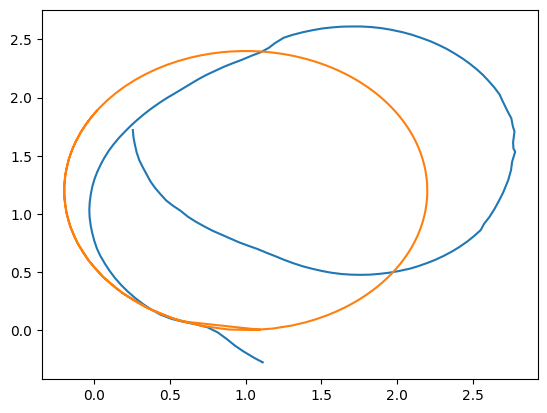

In [4]:
plt.plot(obs_np[:, 0], obs_np[:, 1])
plt.plot(targets[:, 0, 0], targets[:, 0, 1])

In [10]:
##Load Sim DATA
log_dir = '/Users/wenlixiao/Dropbox/School/Graduate/LeCAR/safe-learning-control/playground/car_dynamics/car_dynamics/tmp/oval_log.json'
with open(log_dir, "r") as f:
    data = json.load(f)
obs_np = np.array(data['obs'])
targets = np.array(data['target'])
mppi_actions = np.array(data['mppi_actions'])
action_list = np.array(data['action'])

In [19]:
def plot(N, K=4, zoom_x0=-2, zoom_x1=4,zoom_y0=-2, zoom_y1=4, MAX_VEL=8,MPPI_STEER_PROJ = .48, 
         MPPI_STEER_SHIFT = -0.08, DELAY=0., visualize_mppi=False, visualize_waypoint=False,
        real_psi=False, real_v=False, atan2=False):
    
    DT=0.125
    H=0
    dt=DT
    psi_factor=1.53
    
    model_params = KinematicParams(
                    num_envs=1,
                    last_diff_vel=torch.zeros([1, 1]).to(DEVICE),
                    KP_VEL=7.,
                    KD_VEL=.02,
                    MAX_VEL=MAX_VEL,
                    PROJ_STEER=MPPI_STEER_PROJ,
                    SHIFT_STEER=MPPI_STEER_SHIFT,
                    DT=DT,
    )   

    
    ## Load KBM Model
    dynamics = KinematicBicycleModel(model_params, device=DEVICE)
    dynamics.reset()
    plt.plot(obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 0], obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 1], alpha=0.1)

    real_k_trajectory = obs_np[N:N+K+1]
    action_k_trajectory = action_list[max(0,N-DELAY):N+K+1]
    plt.scatter(real_k_trajectory[:, 0], real_k_trajectory[:, 1], marker='o', s=5, color='red', alpha=0.5, label='real trajectory')

    # # Predict k steps
    # obs_init = real_k_trajectory[0, :4]
    # pred_k_trajectory = [obs_init]
    # for i in range(len(action_k_trajectory)-1):
    #     new_obs = dynamics.single_step_numpy(pred_k_trajectory[-1], action_k_trajectory[i])
    #     # new_obs[3] = real_k_trajectory[i+1, 3]
    #     # new_obs[2] = real_k_trajectory[i+1, 2]
    #     pred_k_trajectory.append(new_obs)
    # pred_k_trajectory = np.array(pred_k_trajectory)
    # plt.scatter(pred_k_trajectory[:, 0], pred_k_trajectory[:, 1], marker='x', s=10, color='green', alpha=0.5, label='predict trajectory')

    # Predict k steps
    obs_init = real_k_trajectory[0, :4]
    # pred_k_trajectory = real_k_trajectory[0:H, :4].tolist()
    pred_k_trajectory_kbm = real_k_trajectory[0:1, :4].tolist()
    for i in range(H-1, len(action_k_trajectory)-1):
        ## KBM
        new_obs_kbm = dynamics.single_step_numpy(np.array(pred_k_trajectory_kbm[-1]), action_k_trajectory[i])
        # new_obs_kbm[3] = real_k_trajectory[i+1, 3]
        pred_k_trajectory_kbm.append(new_obs_kbm)
        ####
    pred_k_trajectory_kbm = np.array(pred_k_trajectory_kbm)
    plt.scatter(pred_k_trajectory_kbm[H:, 0], pred_k_trajectory_kbm[H:, 1], marker='x', s=10, color='blue', alpha=0.5, label='predict trajectory (kbm)')
    # plt.scatter(pred_k_trajectory[H:, 0], pred_k_trajectory[H:, 1], marker='x', s=10, color='green', alpha=0.5, label='predict trajectory (NN)')
    
    
    # MPPI Trajectory
    action_N_mppi = mppi_actions[N]
    mppi_k_trajectory = [obs_init]
    for a_mppi in action_N_mppi:
        new_obs = dynamics.single_step_numpy(mppi_k_trajectory[-1], a_mppi)
        mppi_k_trajectory.append(new_obs)
    mppi_k_trajectory = np.array(mppi_k_trajectory)
    if visualize_mppi:
        plt.scatter(mppi_k_trajectory[:, 0], mppi_k_trajectory[:, 1], marker='^', s=10, color='cyan', alpha=0.5, label='mppi predict trajectory')

    ## Visualize Reference point
    if visualize_waypoint:
        plt.scatter(targets[N][:, 0],targets[N][:,1], marker='x', color='red', label='waypoint')
        # plt.plot(obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 5], obs_np[max(0,N-10):min(N+K+10,obs_np.shape[0]), 6], alpha=0.2)
    
    
    plt.axis('equal')
    plt.legend()
    # plt.xlim([zoom_x0,zoom_x1]) 
    # plt.ylim([zoom_y0, zoom_y1])
interact(
    plot,
    N=(0, obs_np.shape[0], 1),
    K=(0, 30,1),
    zoom_x0=(-2,4,0.1),
    zoom_x1=(-2,4,0.1),
    zoom_y0=(-2,4,0.1),
    zoom_y1=(-2,4,0.1),
    DELAY=(0,10,1),
    MPPI_STEER_PROJ=(-1, 1, 0.01),
    MPPI_STEER_SHIFT=(-np.pi, np.pi, 0.01),
    visualize_mppi=[False, True],
    visualize_waypoint=[False, True],
)

interactive(children=(IntSlider(value=400, description='N', max=801), IntSlider(value=4, description='K', max=…

<function __main__.plot(N, K=4, zoom_x0=-2, zoom_x1=4, zoom_y0=-2, zoom_y1=4, MAX_VEL=8, MPPI_STEER_PROJ=0.48, MPPI_STEER_SHIFT=-0.08, DELAY=0.0, visualize_mppi=False, visualize_waypoint=False, real_psi=False, real_v=False, atan2=False)>

## One Step Error

In [1]:
def one_step_error(start_idx=334, end_idx=2000,DT=0.06, MAX_VEL=5.,MPPI_STEER_PROJ = .34, MPPI_STEER_SHIFT = 0., DELAY=0):

    model_params = KinematicParams(
                    num_envs=1,
                    last_diff_vel=torch.zeros([1, 1]).to(DEVICE),
                    KP_VEL=7.,
                    KD_VEL=.02,
                    MAX_VEL=MAX_VEL,
                    PROJ_STEER=MPPI_STEER_PROJ,
                    SHIFT_STEER=MPPI_STEER_SHIFT,
    )   
    dynamics = KinematicBicycleModel(model_params, device=DEVICE)
    ground_truth = []
    pred_traj = []
    for i in range(len(action_list) - 1):
        # dynamics.reset()
        # print("input", obs_np[i, :4], action_list[i])
        new_obs = dynamics.single_step_numpy(obs_np[i, :4], action_list[i])
        # print(obs_np[i])
        pred_traj.append(new_obs)
        ground_truth.append(obs_np[i+1, :4])
        # print(new_obs[2], obs_np[i+1,2])

    pred_traj = np.array(pred_traj)
    ground_truth = np.array(ground_truth)
    error_yaw = np.arctan2(np.sin(pred_traj[:, 2] - ground_truth[:, 2]), np.cos(pred_traj[:, 2] - ground_truth[:, 2]))
    # plt.plot(error_yaw, alpha=0.5)
    dist = np.linalg.norm(pred_traj - ground_truth, axis=-1)
    # return pred_traj, ground_truth, error_yaw
    # plt.plot(error_yaw)
    plt.plot(dist[start_idx:end_idx])
    plt.title("dynamics prediction error")
    # plt.yscale('log')
interact(
    one_step_error,
    start_idx=(0,len(action_list),1),
    end_idx=(0,len(action_list),1),
)

NameError: name 'interact' is not defined

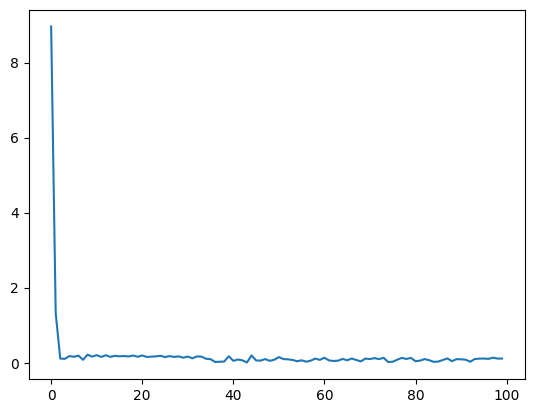

In [23]:
one_step_error()

## DEBUG Dynamic Bicycle Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from offroad.utils import load_state
import json
import matplotlib
from ipywidgets import interact
from car_dynamics.models_torch import MLP
from car_dynamics.envs import make_env, KinematicBicycleModel, KinematicParams, DynamicBicycleModel, DynamicParams
from car_dynamics.controllers_torch import MPPIController, rollout_fn_select, reward_track_fn
import matplotlib.colors as colors
from car_dynamics.models_torch import MLP, parse_data_end2end_norm 
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2


In [6]:
DT=0.05
N_ENVS = 100
model_params = DynamicParams(
                    num_envs=N_ENVS, DT=DT,
)   

dynamics = DynamicBicycleModel(model_params, device=DEVICE)
# rollout_fn = rollout_fn_select('dbm', dynamics, DT, model_params.LF+model_params.LR, model_params.LR)

In [23]:
H = 10
x = torch.zeros(N_ENVS, device=DEVICE)
y = torch.zeros(N_ENVS, device=DEVICE)
psi = torch.zeros(N_ENVS, device=DEVICE)
vx = torch.zeros(N_ENVS, device=DEVICE) + 0.
vy = torch.zeros(N_ENVS, device=DEVICE) + 0.
omega = torch.zeros(N_ENVS, device=DEVICE)
target_vel = torch.ones(N_ENVS, H, device=DEVICE) * 0.5
# target_steer = torch.rand(N_ENVS, device=DEVICE) * 2. - 1.
target_steer = torch.rand(N_ENVS, H, device=DEVICE)

traj_list = []
for i in range(H):
    traj_list.append([x.cpu().numpy().tolist(), y.cpu().numpy().tolist()])
    x, y, psi, vx, vy, omega = dynamics.step(x, y, psi, vx, vy, omega, target_vel[:,i], target_steer[:,i])
traj_list = np.array(traj_list)

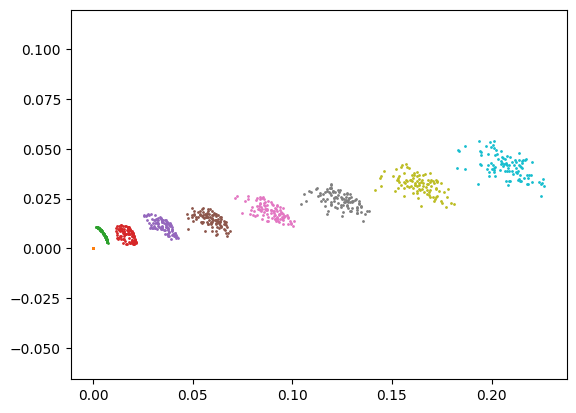

In [25]:
%matplotlib inline
for traj in traj_list:
    # plt.plot(traj_list[:, 0, 0], traj_list[:, 1, 0], color='blue')
    # plt.scatter(traj_list[0, 0, 0], traj_list[0, 1, 0])
    plt.scatter(traj[0, :], traj[1, :], s=1)
    plt.axis('equal')
plt.show()
